In [ ]:
import requests
import pandas as pd
import io
import chess.pgn
from tqdm import tqdm

import csv as C
import numpy as N
import pandas as P
import matplotlib as M
import scipy as S
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ttest_ind, ttest_rel
from scipy.stats import shapiro
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import kruskal
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr

import statsmodels
from statsmodels.stats import multitest

In [218]:
def get_archives(username):
    """List monthly archive URLs for a given Chess.com username."""
    url = f"https://api.chess.com/pub/player/{username}/games/archives"
    r = requests.get(url, headers={"User-Agent": "MyChessProject/1.0 (email@example.com)"})
    if r.status_code != 200:
        print(f"Could not fetch archives for {username}")
        return []
    return r.json()["archives"]

def get_games_from_archive(url):
    """Fetch games from a specific archive URL."""
    r = requests.get(url, headers={"User-Agent": "MyChessProject/1.0 (email@example.com)"})
    r.raise_for_status()
    return r.json().get("games", [])

def fetch_user_games(username, limit_months=3):
    """Fetch up to N months of games for a user."""
    archives = get_archives(username)[-limit_months:]
    games = []
    for url in tqdm(archives, desc=f"Fetching {username}"):
        games += get_games_from_archive(url)
    return games

# Example: multiple players
players = ['maximaan', 'SuoknuutiMax']
all_games = []
for p in players:
    all_games.extend(fetch_user_games(p, limit_months=6))
len(all_games)


Fetching SuoknuutiMax: 100%|██████████████████████████████| 4/4 [00:07<00:00,  1.98s/it]


4554

In [219]:
def extract_game_info(game_json):
    pgn = game_json.get("pgn")
    if not pgn:
        return None

    g = chess.pgn.read_game(io.StringIO(pgn))
    board = g.board()
    moves_san = []
    opening_info = None
    for move in g.mainline_moves():
        san = board.san(move)
        moves_san.append(san)
        board.push(move)
        

    tags = g.headers
    return {
        "eco": opening_info.eco if opening_info else tags.get("ECO"),
        "opening": opening_info.name if opening_info else tags.get("Opening"),
        "white": tags.get("White"),
        "black": tags.get("Black"),
        "white_elo": tags.get("WhiteElo"),
        "black_elo": tags.get("BlackElo"),
        "result": tags.get("Result"),
        "time_control": tags.get("TimeControl"),
        "termination": tags.get("Termination"),
        "date": tags.get("UTCDate"),
        "moves": moves_san,  # full move list
        "num_moves": len(moves_san)
    }

df = pd.DataFrame([extract_game_info(g) for g in all_games if extract_game_info(g)])

    


In [220]:
df2 = df

In [221]:
df2.head

<bound method NDFrame.head of       eco opening             white             black white_elo black_elo  \
0     D00    None          maximaan  albertsiisiainen       596       447   
1     B12    None  albertsiisiainen          maximaan       442       601   
2     A40    None          maximaan  albertsiisiainen       590       454   
3     B13    None  albertsiisiainen          maximaan       465       579   
4     A11    None            Ronjih          maximaan       368       583   
...   ...     ...               ...               ...       ...       ...   
4549  C40    None      SuoknuutiMax             qag26       507       519   
4550  C40    None      SuoknuutiMax      DirtWaterFox       515       494   
4551  B01    None         mfabil555      SuoknuutiMax       567       508   
4552  B01    None        badas58120      SuoknuutiMax       508       500   
4553  B01    None        Isaac_Sanz      SuoknuutiMax       489       492   

     result time_control                     

In [222]:
# write to csv

df2.to_csv('chess-noobs.csv')

In [196]:
# parse opponents into 'opponent'

df3 = df2.copy() # df2 contains the original non modified df 

# df3 replace opponents with 'opponent' for easier analysis
df3['white'] = df3['white'].apply(lambda x: x if x in players else 'opponent')
df3['black'] = df3['black'].apply(lambda x: x if x in players else 'opponent')

# if players in target list play one another
dfvs = df2[
    (df2['white'].isin(players)) &
    (df2['black'].isin(players))
].copy()

In [197]:
dfvs.head

<bound method NDFrame.head of       eco opening          white         black white_elo black_elo   result  \
40    A04    None         Hikaru  Firouzja2003      3306      3208      0-1   
89    B15    None   Firouzja2003        Hikaru      3267      3322  1/2-1/2   
146   A20    None  MagnusCarlsen        Hikaru      3314      3349      0-1   
147   C47    None         Hikaru        DenLaz      3345      3187  1/2-1/2   
433   C65    None   Firouzja2003        Hikaru      3264      3285      1-0   
...   ...     ...            ...           ...       ...       ...      ...   
5586  A30    None   Firouzja2003        DenLaz      3321      3211      1-0   
5587  C67    None         Hikaru  Firouzja2003      3344      3322  1/2-1/2   
5660  B11    None         Hikaru  Firouzja2003      3389      3313  1/2-1/2   
5743  C67    None   Firouzja2003        Hikaru      3187      3352  1/2-1/2   
5750  D30    None         DenLaz  Firouzja2003      3212      3174      0-1   

     time_control    

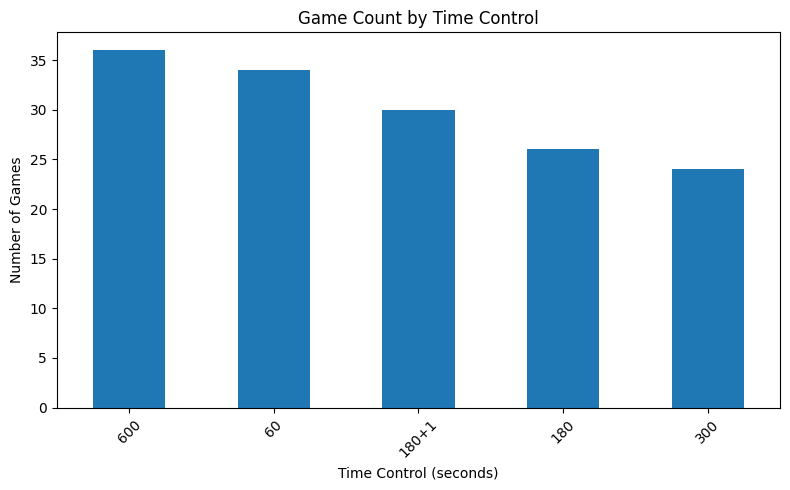

In [214]:
counts = dfvs['time_control'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(8,5))
counts.plot(kind='bar')

plt.title('Game Count by Time Control')
plt.xlabel('Time Control (seconds)')
plt.ylabel('Number of Games')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

array([[<Axes: title={'center': 'num_moves'}>]], dtype=object)

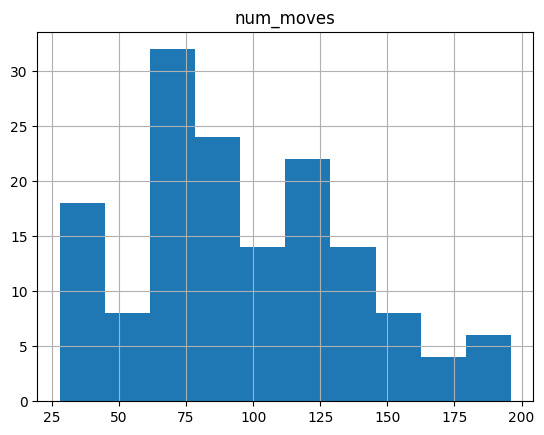

In [212]:
dfvs.hist()

In [200]:
df3['whitewin'] = N.where(df2['result'] == '1-0', 1,
                   N.where(df2['result'] == '1/2-1/2', 2, 0))

# black wins
df3['blackwin'] = N.where(df2['result'] == '0-1', 1,
                   N.where(df2['result'] == '1/2-1/2', 2, 0))

In [201]:
players_long = P.concat([
    df3[['white', 'white_elo', 'whitewin', 'moves']].rename(columns={
        'white': 'player', 'white_elo': 'elo', 'whitewin': 'result_flag', 'moves': 'moves'
    }).assign(color='white'),
    df3[['black', 'black_elo', 'blackwin', 'moves']].rename(columns={
        'black': 'player', 'black_elo': 'elo', 'blackwin': 'result_flag', 'moves': 'moves'
    }).assign(color='black')
])
    

            
        
    

In [202]:
players_long['elo'] = pd.to_numeric(players_long['elo'], errors='coerce')

In [224]:
dfvs['termination'].value_counts

<bound method IndexOpsMixin.value_counts of 40          Firouzja2003 won by resignation
89                 Game drawn by repetition
146                      Hikaru won on time
147     Game drawn by insufficient material
433                Firouzja2003 won on time
                       ...                 
5586               Firouzja2003 won on time
5587               Game drawn by repetition
5660                Game drawn by agreement
5743               Game drawn by repetition
5750               Firouzja2003 won on time
Name: termination, Length: 150, dtype: object>

In [223]:
summary = (
    players_long
    .groupby(['player', 'color'])
    .agg(
        wins=('result_flag', lambda x: (x == 1).sum()),
        losses=('result_flag', lambda x: (x == 0).sum()),
        draws=('result_flag', lambda x: (x == 2).sum()),
        
        avg_elo=('elo', 'mean')
    )
    .reset_index()
)
summary['winrate'] = summary['wins'] / (summary['wins'] + summary['losses'] + summary['draws'])


summary

,player,color,wins,losses,draws,avg_elo,winrate
0,DenLaz,black,185,84,63,3151.457831,0.557229
1,DenLaz,white,228,58,43,3145.407295,0.693009
2,Firouzja2003,black,308,102,65,3256.911579,0.648421
3,Firouzja2003,white,338,101,53,3258.784553,0.686992
4,Hikaru,black,1347,175,134,3324.892512,0.813406
5,Hikaru,white,1458,134,115,3275.867604,0.854130
6,MagnusCarlsen,black,347,111,47,3230.859406,0.687129
7,MagnusCarlsen,white,363,94,44,3225.087824,0.724551
8,opponent,black,345,2327,207,2904.264675,0.119833
9,opponent,white,412,2145,261,2928.479773,0.146203


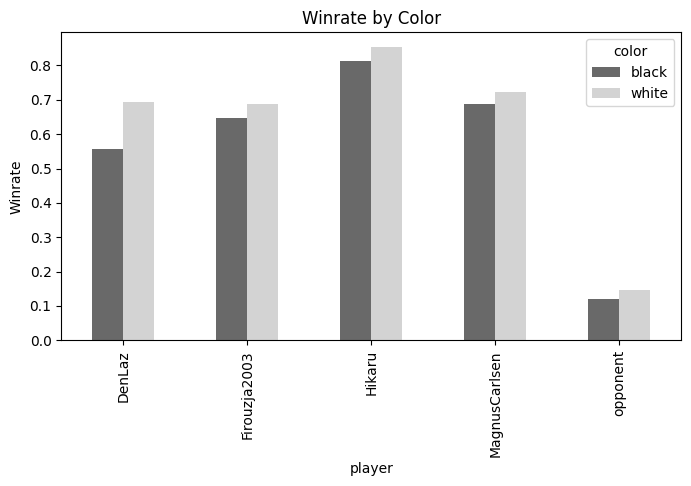

In [207]:

colors=['dimgray','lightgray']
pivot = summary.pivot(index='player', columns='color', values='winrate')
pivot.plot(kind='bar', figsize=(8,4), title='Winrate by Color', color=colors)
plt.ylabel('Winrate')
plt.show()

viusalizing that white has a slightly higher winrate overall

<Axes: ylabel='player'>

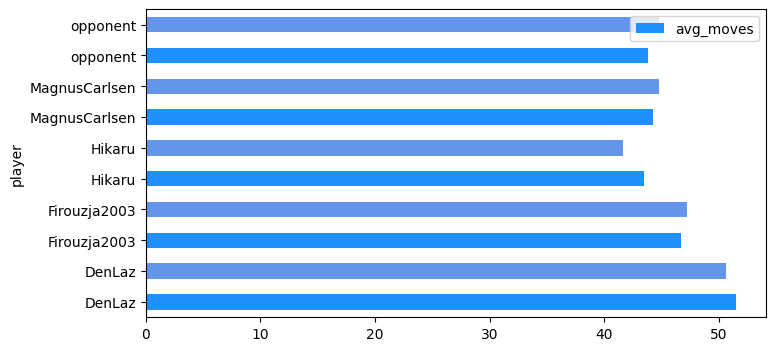

In [205]:
summary.plot(
    kind='barh', x='player', y='avg_moves',
    color=['#6495ED' if c=='white' else '#1E90FF' for c in summary['color']],
    figsize=(8,4)
)

In [165]:
players_long.head()

,player,elo,result_flag,moves,color
0,opponent,2579,0,33,white
1,Hikaru,3316,0,34,white
2,Hikaru,3316,1,23,white
3,opponent,2694,0,49,white
4,Hikaru,3317,1,40,white
